In [9]:
from __future__ import division
from __future__ import print_function

import argparse
import time

import numpy as np
import scipy.sparse as sp
import torch
import torchvision
from torch import optim
import pandas as pd
import os

from gae.model import GCNModelVAE

from gae.optimizer import loss_function
from gae.utils import load_data, mask_test_edges, preprocess_graph, get_roc_score

import import_ipynb
from ram_mediapipe import mediapipe

<!-- GAE : Ram -->

In [10]:
parser = argparse.ArgumentParser()
parser.add_argument('--model', type=str, default='gcn_vae', help="models used")
parser.add_argument('--seed', type=int, default=42, help='Random seed.')
parser.add_argument('--epochs', type=int, default=5, help='Number of epochs to train.')
parser.add_argument('--hidden1', type=int, default=32, help='Number of units in hidden layer 1.')
parser.add_argument('--hidden2', type=int, default=16, help='Number of units in hidden layer 2.')
parser.add_argument('--lr', type=float, default=0.01, help='Initial learning rate.')
parser.add_argument('--dropout', type=float, default=0., help='Dropout rate (1 - keep probability).')
parser.add_argument('--dataset-str', default='cora', help='type of dataset.')

args, unknown = parser.parse_known_args()

In [11]:
def gae_for(path):
    # Calling mediapipe for adjacency matrix and feature matrix
    # adj: Type=scipy.sparse._csr.csr_matrix, Shape=(468,468)
    # Features: Type=torch.Tensor, Shape=(468,468)
    adj,features=mediapipe(path)
    # n_nodes= 468, feat_dim=468
    n_nodes, feat_dim = features.shape 
    adj_orig = adj
    # adj_orig.diagonal() = all diagonal elements. Eg: [0,0,0,.....0], Shape = (1,468), 1 Dimensional
    # adj_orig.diagonal()[np.newaxis, :] = [[0,0,0,....,0]], Shape = (1,468), 2 Dimensional
    # sp.dia_matrix = sparse matrix with diagonal storage
    # sp.dia_matrix((data,offsets),shape) : data = [[0,0,0,...,0]], offsets = [0], and shape = (468,468)
    # subtractiong adj matrix with 468*468 matrix of zeros. ( Remove diagonal elements )
    adj_orig = adj_orig - sp.dia_matrix((adj_orig.diagonal()[np.newaxis, :], [0]), shape=adj_orig.shape) 
    # eliminating zeros
    adj_orig.eliminate_zeros()
    # calling mask_test_edges() function, present in utils
    adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
    # 198 edges and lower triangular values are removed from original matrix. 
    adj = adj_train
    print("val_edges_false=",len(test_edges_false))
    # print(train_edges.shape,test_edges,test_edges_false)
    # normalize adj matrix : Tilda A = (adj + feature) * pow(D,.5) * pow(D,.5)
    adj_norm = preprocess_graph(adj)
    # adj + features
    adj_label = adj_train + sp.eye(adj_train.shape[0])
    # cerating array of tensor type
    adj_label = torch.FloatTensor(adj_label.toarray())
    # 468 * 468 - 2248 / 2248
    # pos_weight= tensor([96.4306])
    pos_weight = torch.Tensor([float(adj.shape[0] * adj.shape[0] - adj.sum()) / adj.sum()])
    # 468 * 468 / ((468 * 468) - 2248) * 2
    # norm= 0.5051850758386537
    norm = adj.shape[0] * adj.shape[0] / float((adj.shape[0] * adj.shape[0] - adj.sum()) * 2)
    # calling GCNModelVAE, passing shape, hidden1 hidden2, dropout
    model = GCNModelVAE(feat_dim, args.hidden1, args.hidden2, args.dropout)
    optimizer = optim.Adam(model.parameters(), lr=args.lr)

    hidden_emb = None
    for epoch in range(args.epochs):
        t = time.time()
        model.train()
        optimizer.zero_grad()
        recovered, mu, logvar, z = model(features, adj_norm)
        loss = loss_function(preds=recovered, labels=adj_label,
                             mu=mu, logvar=logvar, n_nodes=n_nodes,
                             norm=norm, pos_weight=pos_weight)
        loss.backward()
        cur_loss = loss.item()
        optimizer.step()

        hidden_emb = mu.data.numpy()
        roc_curr, ap_curr = get_roc_score(hidden_emb, adj_orig, val_edges, val_edges_false)
        # print("Epoch:", '%04d' % (epoch + 1), "train_loss=", "{:.5f}".format(cur_loss),
        #       "val_ap=", "{:.5f}".format(ap_curr),
        #       "time=", "{:.5f}".format(time.time() - t)
        #       )

    print("Optimization Finished!")
    
    roc_score, ap_score = get_roc_score(hidden_emb, adj_orig, test_edges, test_edges_false)
    return(z)


edges_mediapipe= 2556 1278.0
sparse_mx <class 'scipy.sparse._coo.coo_matrix'> (468, 468)
sparse_mx <class 'scipy.sparse._coo.coo_matrix'> (468, 468)
data= (1124,)
val_edges_false= 132
norm= 0.5051850758386537
Optimization Finished!


tensor([[-0.5723,  0.0356, -0.1670,  ..., -0.5712, -0.7108,  0.4748],
        [ 0.6352, -0.4507,  0.0738,  ..., -1.8387,  2.1417,  1.7846],
        [-0.2653, -0.3591, -1.0820,  ..., -0.4765, -0.5261,  2.2994],
        ...,
        [-1.4679, -0.1376,  0.6119,  ...,  0.6747,  1.0167,  0.7822],
        [-0.3626, -0.3064, -1.3702,  ...,  0.0198,  0.2074, -0.9668],
        [-1.3510, -1.0002,  0.2527,  ...,  0.5348,  1.4378, -0.5787]],
       grad_fn=<AddBackward0>)

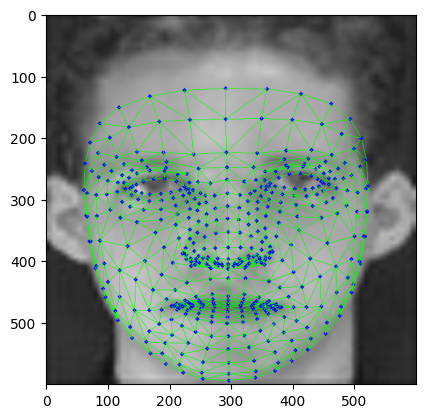

In [12]:
gae_for("./orl_dataset/person1/train_images/1_1.jpg")